Output function is calculated in the similar way as a CA-1A.

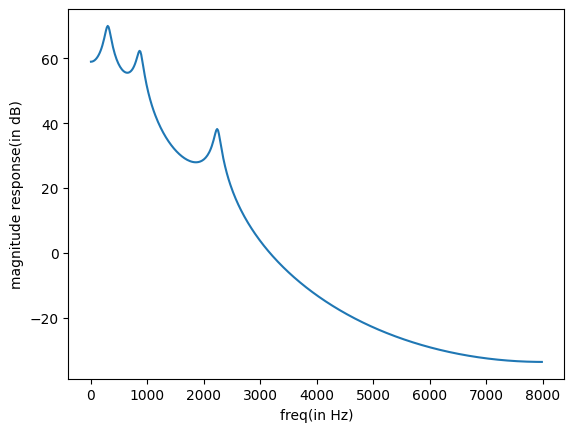

In [577]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
from scipy import signal
from scipy.signal import zpk2tf,freqz,sawtooth,square,impulse
from scipy.fft import fft,fftfreq
from numpy import exp,zeros_like,cos,sin,log10,angle,hamming
from numpy import convolve as conv

def output(f0):

  F1 = 300
  F2 = 870
  F3 = 2240
  B = 100
  fs = 16000
  T = 1/fs
  theta1 = 2*np.pi*F1*T
  theta2 = 2*np.pi*F2*T
  theta3 = 2*np.pi*F3*T
  duration = 0.505  # Duration of the signal in second
  pulse_period = 1/f0 # Period of the pulse train

  r = np.exp(-1*B*np.pi*T)


# Get poles and an equal number of zeros
  poles = [r*np.exp(1j*theta1), r * np.exp(-1j*theta1), r * np.exp(1j*theta2), r * np.exp(-1j*theta2), r * np.exp(1j*theta3), r * np.exp(-1j*theta3)]

  num = 1
  den = np.poly(poles)

  w, h = freqz(num, den)
  freq = w * fs / (2 * np.pi)
  mag = 20 * np.log10(abs(h))

  t = np.linspace(0, duration, int(duration * fs), endpoint=False)

# Generate the narrow triangular pulse train
  pulse_train = signal.square(2 * np.pi * f0 * t, duty = 0.01) + 1

  n1 = np.arange(0,8000,1)
  y1 = np.zeros(len(n1))
  for i in range(len(n1)):
    if i == 0:
      y1[i] = pulse_train[i]
    elif i == 1:
      y1[i] = -den[1]*y1[i-1] + pulse_train[i]
    elif i == 2:
      y1[i] = -den[1]*y1[i-1] -den[2]*y1[i-2] + pulse_train[i]
    elif i == 3:
      y1[i] = -den[1]*y1[i-1] -den[2]*y1[i-2]- den[3]*y1[i-3] + pulse_train[i]
    elif i == 4:
      y1[i] = -den[1]*y1[i-1] -den[2]*y1[i-2]- den[3]*y1[i-3] - den[4]*y1[i-4] + pulse_train[i]
    elif i == 5:
      y1[i] = -den[1]*y1[i-1] -den[2]*y1[i-2]- den[3]*y1[i-3] - den[4]*y1[i-4] - den[5]*y1[i-5] + pulse_train[i]
    else :
      y1[i] = -den[1]*y1[i-1] -den[2]*y1[i-2]- den[3]*y1[i-3] - den[4]*y1[i-4] - den[5]*y1[i-5] - den[6]*y1[i-6] + pulse_train[i]

  return n1/fs, y1
plt.plot(freq, mag)
plt.xlabel('freq(in Hz)')
plt.ylabel('magnitude response(in dB)')
plt.show()


Rectangular and Hamming windows are defined. The DFT function in case of two window function is also calculated. And the estimated values of the fundamental frequencies are its harmonics is calculated.

In [578]:
def rectangular_window(win_length,fs,output_signal,f0):
    """
    """
    window_size = int(win_length*fs/1000)
    window_signal = output_signal[:window_size]
    dft = fft(window_signal, n=1024)
    freq = fftfreq(dft.shape[-1], 1/fs)
    len_ = int(len(dft)/2)

    peaks = np.where(dft > np.mean(dft))[0]
    f0_index = np.argmax(np.abs(dft))
    estimated_F0 = freq[f0_index]
    mask = np.ones(len(peaks), dtype=bool)
    mask[f0_index] = False
    remaining_peaks = peaks[mask]
    second_best_index = np.argmin(np.abs(freq[remaining_peaks] - 300))
    estimated_F1 = freq[remaining_peaks[second_best_index]]
    estimated_F2 = freq[peaks[np.argmin(np.abs(freq[peaks] - 870))]]
    estimated_F3 = freq[peaks[np.argmin(np.abs(freq[peaks] - 2440))]]

    error_0 = np.subtract(estimated_F0, f0)
    error_1 = np.subtract(estimated_F1, F1)
    error_2 = np.subtract(estimated_F2, F2)
    error_3 = np.subtract(estimated_F3, F3)

    print(f"Estimated value of F0 is {estimated_F0}, Estimated value of F1 is {estimated_F1}, Estimated value of F2 is {estimated_F2}, Estimated value of F3 is {estimated_F3}")
    print(f"error in F0 is {abs(error_0)}, error in F1 is {abs(error_1)}, error in F2 is {abs(error_2)}, error in F3 is {abs(error_3)} ")
    plt.title(f'Magnitude(dB) response with rectangular window of size {win_length}ms and pitch {f0}Hz')
    plt.plot(abs(freq), 20*log10(abs(dft)))
    plt.ylabel(r"$|H(\Omega|$",fontsize=10)
    plt.xlabel(r"$\Omega$")
    plt.xlim(xmin=0)
    plt.grid("True")
    plt.tight_layout()
    plt.show()



In [579]:
def hamming_window(win_length,fs,output_signal,f0):
    """
    """
    window_size = int(win_length*fs/1000)
    window_signal = output_signal[:window_size] * hamming(window_size)
    dft = fft(window_signal, n=1024)
    freq = fftfreq(dft.shape[-1], 1/fs)
    len_ = int(len(dft)/2)

    peaks = np.where(dft > np.mean(dft))[0]
    f0_index = np.argmax(np.abs(dft))
    estimated_F0 = freq[f0_index]
    mask = np.ones(len(peaks), dtype=bool)
    mask[f0_index] = False
    remaining_peaks = peaks[mask]
    second_best_index = np.argmin(np.abs(freq[remaining_peaks] - 300))
    estimated_F1 = freq[remaining_peaks[second_best_index]]
    estimated_F2 = freq[peaks[np.argmin(np.abs(freq[peaks] - 870))]]
    estimated_F3 = freq[peaks[np.argmin(np.abs(freq[peaks] - 2440))]]

    error_0 = np.subtract(estimated_F0, f0)
    error_1 = np.subtract(estimated_F1, F1)
    error_2 = np.subtract(estimated_F2, F2)
    error_3 = np.subtract(estimated_F3, F3)

    print(f"Estimated value of F0 is {estimated_F0}, Estimated value of F1 is {estimated_F1}, Estimated value of F2 is {estimated_F2}, Estimated value of F3 is {estimated_F3}")
    print(f"error in F0 is {abs(error_0)}, error in F1 is {abs(error_1)}, error in F2 is {abs(error_2)}, error in F3 is {abs(error_3)} ")
    plt.title(f'Magnitude(dB) response with rectangular window of size {win_length}ms and pitch {f0}Hz')
    plt.plot(abs(freq), 20*log10(abs(dft)))
    plt.ylabel(r"$|H(\Omega|$",fontsize=10)
    plt.xlabel(r"$\Omega$")
    plt.xlim(xmin=0)
    plt.grid("True")
    plt.tight_layout()
    plt.show()

In [580]:
t_120 , output_signal_120 = output(120) #output signal for 120Hz

In [581]:
t_220 , output_signal_220 = output(220) #output signal for 220 Hz

RECTANGULAR WINDOW AT 120 Hz

Plot of DFT functions in case of rectangular window at 120 Hz is shown along with the estimated values of f0,f1,f2,f3.

Estimated value of F0 is 296.875, Estimated value of F1 is 312.5, Estimated value of F2 is 968.75, Estimated value of F3 is 2437.5
error in F0 is 176.875, error in F1 is 12.5, error in F2 is 98.75, error in F3 is 197.5 


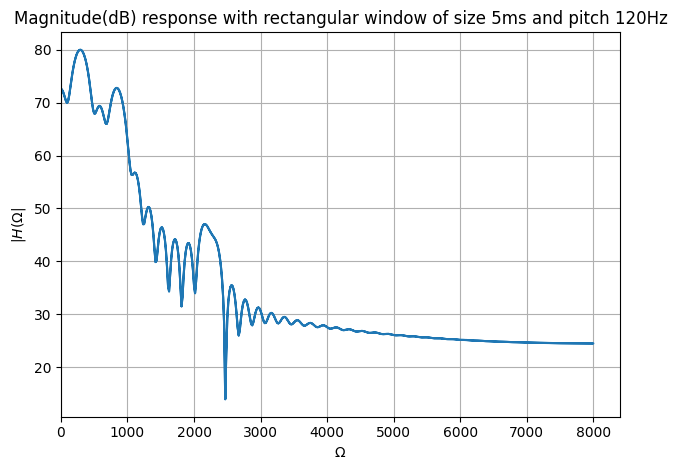

In [582]:
# rectangular window at 120Hz for different window lengths
# window length = 5ms
rectangular_window(5 , fs ,output_signal_120, 120)

Estimated value of F0 is 250.0, Estimated value of F1 is 296.875, Estimated value of F2 is 968.75, Estimated value of F3 is 2437.5
error in F0 is 130.0, error in F1 is 3.125, error in F2 is 98.75, error in F3 is 197.5 


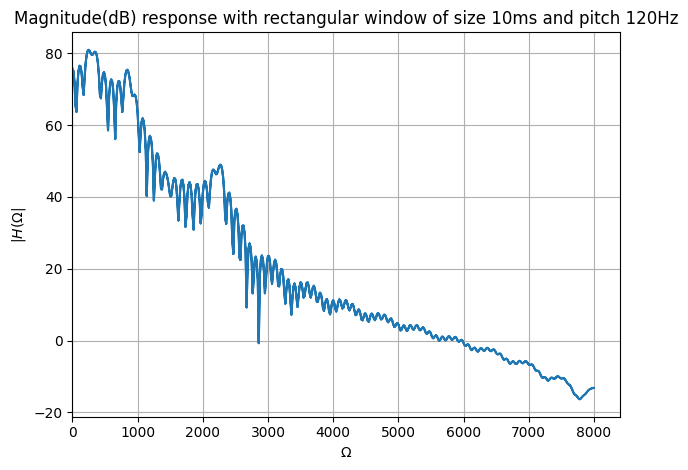

In [583]:
# rectangular window at 120Hz for different window lengths
# window length = 10ms
rectangular_window(10 , fs ,output_signal_120, 120)

Estimated value of F0 is 234.375, Estimated value of F1 is 281.25, Estimated value of F2 is 921.875, Estimated value of F3 is 2437.5
error in F0 is 114.375, error in F1 is 18.75, error in F2 is 51.875, error in F3 is 197.5 


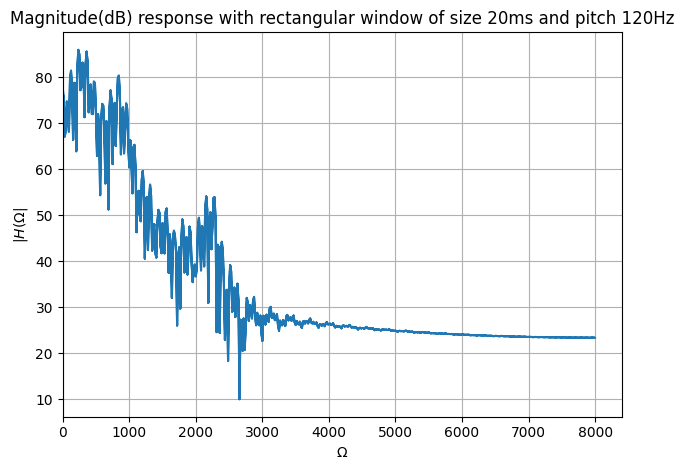

In [584]:
# rectangular window at 120Hz for different window lengths
# window length = 20ms
rectangular_window(20 , fs ,output_signal_120, 120)

Estimated value of F0 is 359.375, Estimated value of F1 is 296.875, Estimated value of F2 is 859.375, Estimated value of F3 is 2437.5
error in F0 is 239.375, error in F1 is 3.125, error in F2 is 10.625, error in F3 is 197.5 


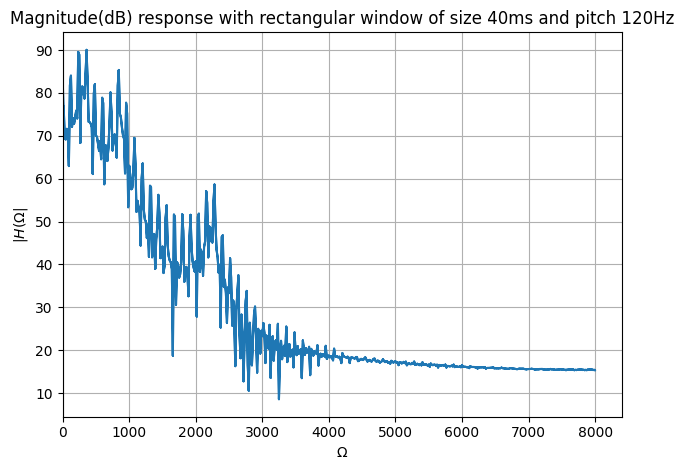

In [585]:
# rectangular window at 120Hz for different window lengths
# window length = 40ms
rectangular_window(40 , fs ,output_signal_120, 120)

RECTANGULAR WINDOW AT 220Hz

Plot of DFT functions in case of rectangular window at 220 Hz is shown along with the estimated values of f0,f1,f2,f3.

Estimated value of F0 is 265.625, Estimated value of F1 is 296.875, Estimated value of F2 is 984.375, Estimated value of F3 is 2437.5
error in F0 is 45.625, error in F1 is 3.125, error in F2 is 114.375, error in F3 is 197.5 


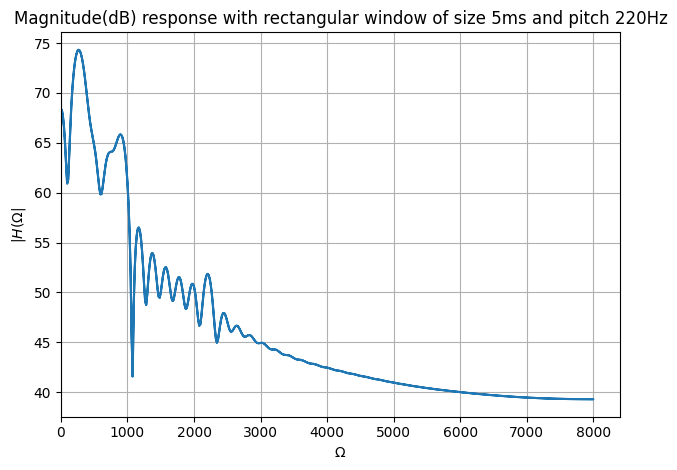

In [586]:
# rectangular window at 220Hz for different window lengths
# window length = 5ms
rectangular_window(5 , fs ,output_signal_220, 220)

Estimated value of F0 is 218.75, Estimated value of F1 is 328.125, Estimated value of F2 is 921.875, Estimated value of F3 is 2437.5
error in F0 is 1.25, error in F1 is 28.125, error in F2 is 51.875, error in F3 is 197.5 


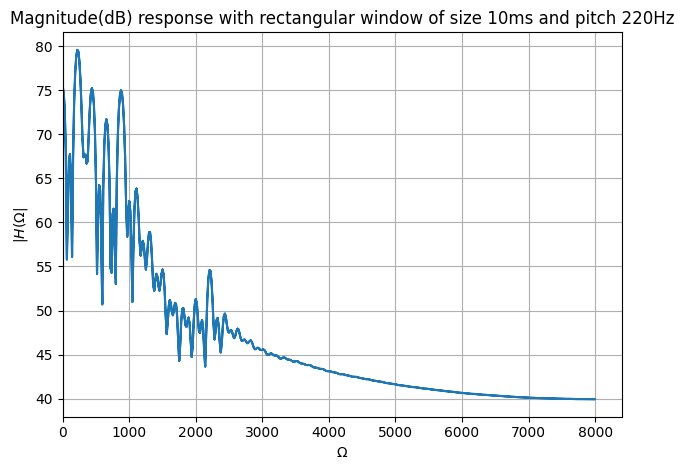

In [587]:
# rectangular window at 220Hz for different window lengths
# window length = 10ms
rectangular_window(10 , fs ,output_signal_220, 220)

Estimated value of F0 is 218.75, Estimated value of F1 is 328.125, Estimated value of F2 is 906.25, Estimated value of F3 is 2437.5
error in F0 is 1.25, error in F1 is 28.125, error in F2 is 36.25, error in F3 is 197.5 


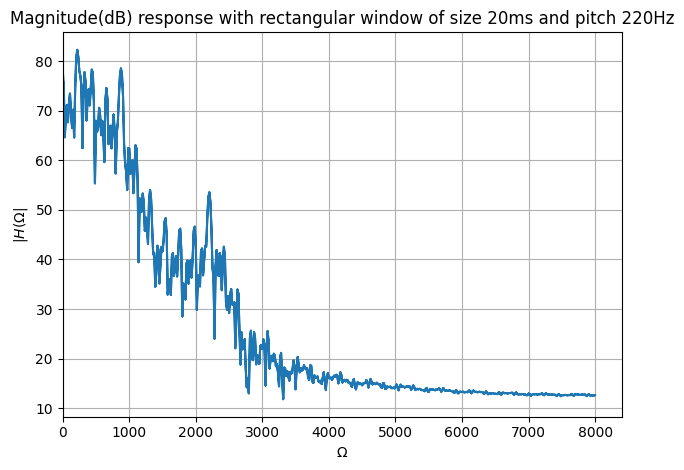

In [588]:
# rectangular window at 220Hz for different window lengths
# window length = 20ms
rectangular_window(20 , fs ,output_signal_220, 220)

Estimated value of F0 is 218.75, Estimated value of F1 is 296.875, Estimated value of F2 is 890.625, Estimated value of F3 is 2453.125
error in F0 is 1.25, error in F1 is 3.125, error in F2 is 20.625, error in F3 is 213.125 


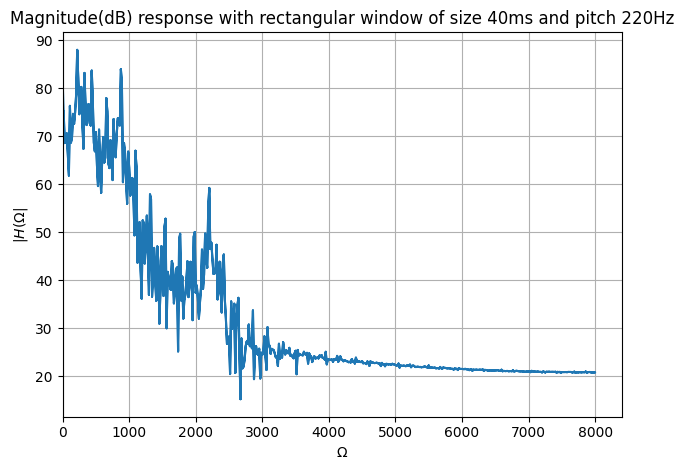

In [589]:
# rectangular window at 220Hz for different window lengths
# window length = 40ms
rectangular_window(40 , fs ,output_signal_220, 220)

HAMMING WINDOW AT 120Hz

Plot of DFT functions in case of hamming window at 120 Hz is shown along with the estimated values of f0,f1,f2,f3.

Estimated value of F0 is 296.875, Estimated value of F1 is 296.875, Estimated value of F2 is 937.5, Estimated value of F3 is 2390.625
error in F0 is 176.875, error in F1 is 3.125, error in F2 is 67.5, error in F3 is 150.625 


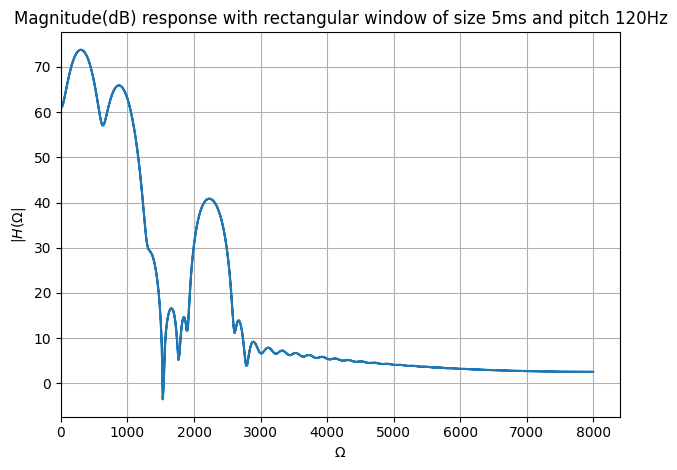

In [590]:
hamming_window(5 , fs ,output_signal_120, 120)

Estimated value of F0 is 296.875, Estimated value of F1 is 296.875, Estimated value of F2 is 906.25, Estimated value of F3 is 2500.0
error in F0 is 176.875, error in F1 is 3.125, error in F2 is 36.25, error in F3 is 260.0 


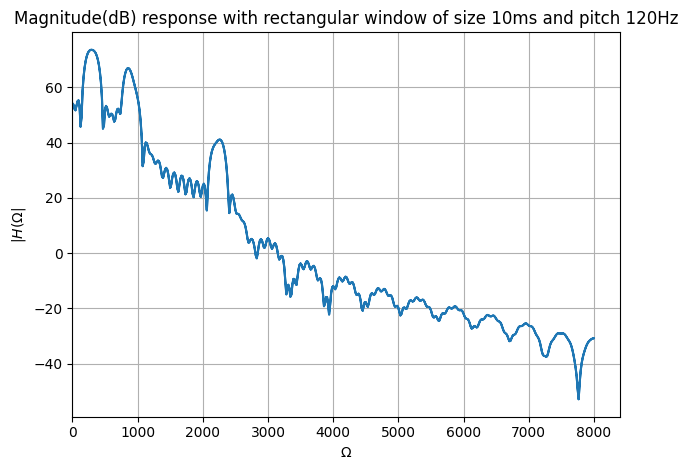

In [591]:
hamming_window(10 , fs ,output_signal_120, 120)

Estimated value of F0 is 234.375, Estimated value of F1 is 312.5, Estimated value of F2 is 875.0, Estimated value of F3 is 2406.25
error in F0 is 114.375, error in F1 is 12.5, error in F2 is 5.0, error in F3 is 166.25 


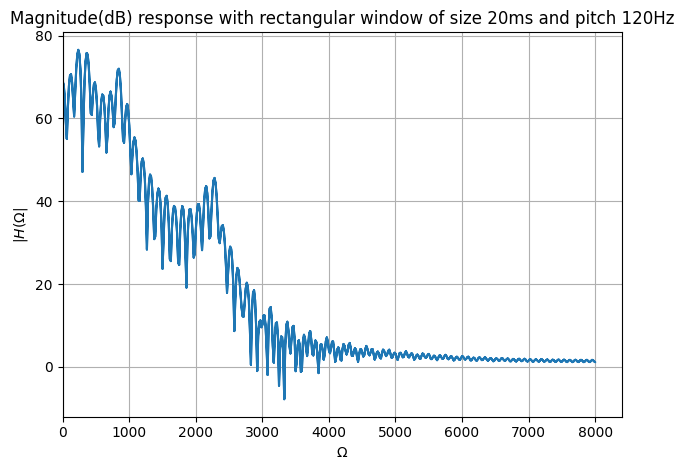

In [592]:
hamming_window(20 , fs ,output_signal_120, 120)

Estimated value of F0 is 234.375, Estimated value of F1 is 296.875, Estimated value of F2 is 859.375, Estimated value of F3 is 2437.5
error in F0 is 114.375, error in F1 is 3.125, error in F2 is 10.625, error in F3 is 197.5 


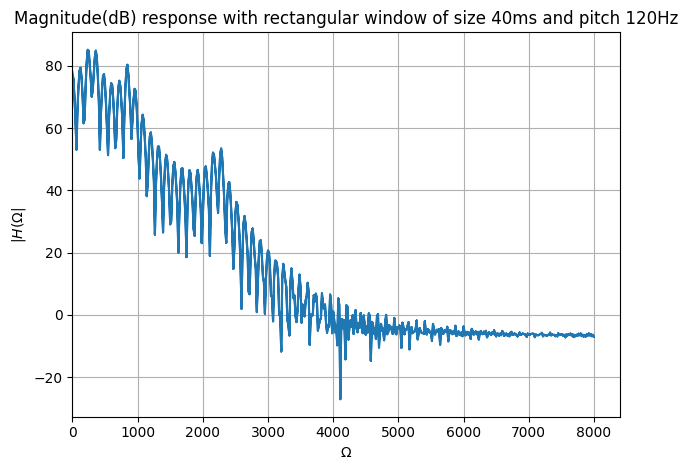

In [593]:
hamming_window(40 , fs ,output_signal_120, 120)

HAMMING WINDOW AT 220Hz

Plot of DFT functions in case of hamming window at 220 Hz is shown along with the estimated values of f0,f1,f2,f3.

Estimated value of F0 is 296.875, Estimated value of F1 is 296.875, Estimated value of F2 is 937.5, Estimated value of F3 is 2390.625
error in F0 is 76.875, error in F1 is 3.125, error in F2 is 67.5, error in F3 is 150.625 


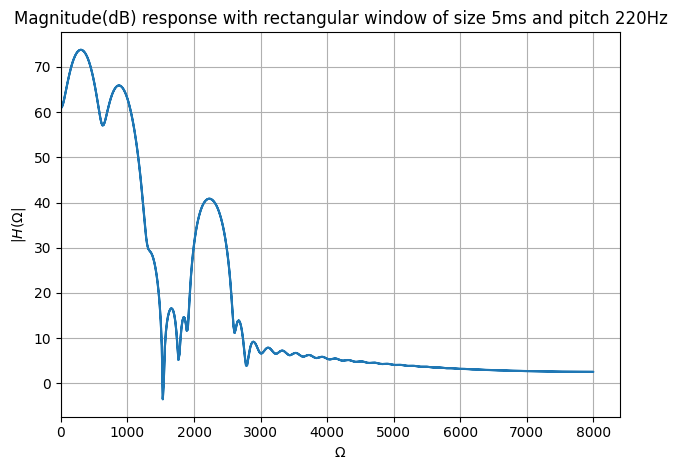

In [594]:
hamming_window(5 , fs ,output_signal_120, 220)

Estimated value of F0 is 296.875, Estimated value of F1 is 296.875, Estimated value of F2 is 906.25, Estimated value of F3 is 2500.0
error in F0 is 76.875, error in F1 is 3.125, error in F2 is 36.25, error in F3 is 260.0 


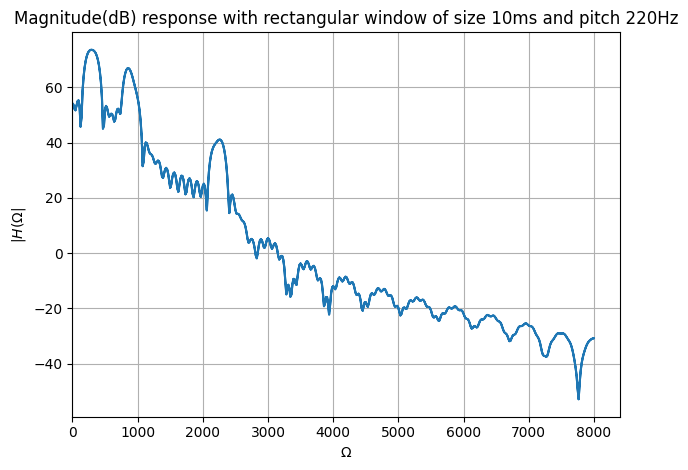

In [595]:
hamming_window(10 , fs ,output_signal_120, 220)

Estimated value of F0 is 234.375, Estimated value of F1 is 312.5, Estimated value of F2 is 875.0, Estimated value of F3 is 2406.25
error in F0 is 14.375, error in F1 is 12.5, error in F2 is 5.0, error in F3 is 166.25 


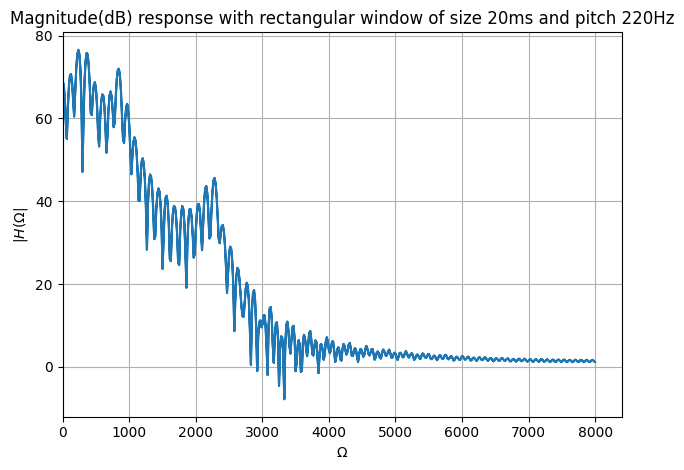

In [596]:
hamming_window(20 , fs ,output_signal_120, 220)

Estimated value of F0 is 234.375, Estimated value of F1 is 296.875, Estimated value of F2 is 859.375, Estimated value of F3 is 2437.5
error in F0 is 14.375, error in F1 is 3.125, error in F2 is 10.625, error in F3 is 197.5 


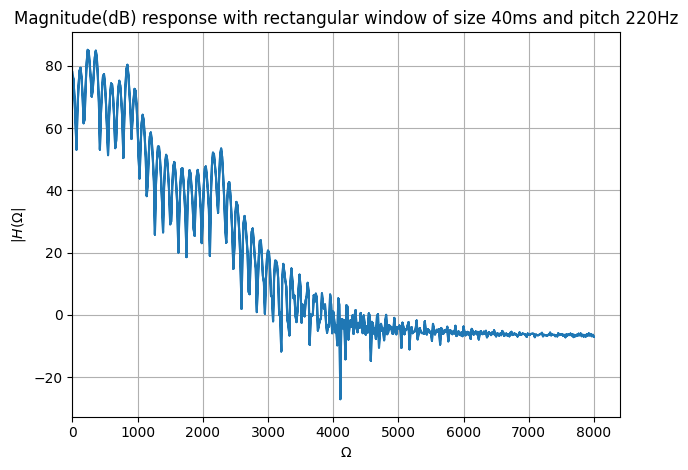

In [597]:
hamming_window(40 , fs ,output_signal_120, 220)

Comments

1.   
As we expand the window size for either the Hamming or Rectangular window, it becomes easier to distinguish the magnitudes of the peaks in the spectrum. However, when it comes to identifying the formant frequencies (F1, F2, and F3), the task becomes a bit more tricky. This is because the peaks start appearing closer to each other. This phenomenon reflects the shift from a wide-band analysis to a narrow-band one, which influences our ability to precisely pinpoint the frequencies we're interested in.
2.   
With smaller window sizes, it's relatively straightforward to calculate the formant frequencies. This is because the broad frequency response of the system causes the peaks to accumulate, resulting in precise formant frequency determination.

3. When the fundamental frequency (F0) increases, it causes a shift in the resonating frequency of the vocal tract. This shift also has an impact on how we detect the formant frequencies. For instance, when F0 is set at 220Hz, we observe that F2 and F3, being close to multiples of 220Hz, are clearly visible in the analysis. However, F1, not being close to a multiple of 220Hz, exhibits a peak at a different frequency. This pattern is similar when F0 is set to 120Hz as well.

4. In the case of using Hamming windowing, the side lobes of the signal are noticeably smaller compared to when the Rectangular window is employed. When using a specific window size, the peaks tend to appear more frequently and are closer together in the Rectangular window.

5. When we keep the same window function but vary the fundamental frequency (F0), we notice that the peaks become more spaced apart. In the case of a higher F0, the waveform's details become more distinct and clear.

